In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import lsst.afw.display.rgb as rgb
from scipy import interpolate

from astropy.table import Table
import matplotlib
import matplotlib.mlab as mlab
import numpy as np

import lsst.afw.display as afwDisplay
from python.simulation_utils import simulation_wrapper, OpSim_wrapper
from python.notebook_utils import look, get_xkcd_color, load_diffim, plot_diffim_quiver, dcr_metric
import lsst.daf.persistence as daf_persistence
from lsst.ip.diffim.dcrModel import calculateDcr

In [2]:
base_dir = "/Users/sullivan/LSST/simulations/OpSim/"

OpSim baseline2018a

In [3]:
opsim_version = "pontus_2568/"

In [4]:
varPSF_run = "mosaic_42_varPSF_rand/"

In [5]:
dcr_rerun_base = "input_data/rerun/processed_data/rerun/seeing_dcr_"
deep_rerun_base = "input_data/rerun/processed_data/rerun/seeing_cw_"

In [6]:
def extract_dcr(field_table, fieldId):
    fields = set(field_table["fieldId"])
    if fieldId not in fields:
        print('ValueError("fieldId not found in table")')
    rows = field_table["fieldId"] == fieldId
    dcr = field_table["dcr"].data[rows]
    return dcr

In [7]:
seeing_id = 1
visits_alerts = [[2000000, 2000023]]

In [8]:
seeing_name = "%i/" % 8
deep_or_dcr = 'deep'
rerun = deep_rerun_base if deep_or_dcr == 'deep' else dcr_rerun_base
butler = daf_persistence.Butler(base_dir + opsim_version + varPSF_run + rerun + seeing_name)
dataId = {'visit': visits_alerts[0][0], 'filter': 'g'}
dia_src = butler.get(deep_or_dcr +"Diff_diaSrc", dataId=dataId)

In [9]:
base_dir + opsim_version + varPSF_run + rerun + seeing_name

'/Users/sullivan/LSST/simulations/OpSim/pontus_2568/mosaic_42_varPSF_rand/input_data/rerun/processed_data/rerun/seeing_cw_8/'

In [10]:
len(dia_src.asAstropy())

109

In [11]:
diffim_dcr = butler.get(deep_or_dcr + "Diff_differenceExp", dataId=dataId)
science_image = butler.get("calexp", dataId=dataId)

In [12]:
dataId2 = {'visit': visits_alerts[0][0], 'filter': 'g', 'raft': '2,2', 'sensor': '1,1'}
match_image = butler.get(deep_or_dcr + "Diff_matchedExp", dataId=dataId2)

In [13]:
pix = science_image.mask.array == 32

In [14]:
pix = pix & np.isfinite(diffim_dcr.image.array)

In [15]:
diffim_test = np.zeros_like(diffim_dcr.image.array)
diffim_test[pix] = diffim_dcr.image.array[pix]

In [16]:
test_im = diffim_dcr.clone()
test_im.setMask(science_image.mask)

In [17]:
import lsst.afw.display as afwDisplay
disp1 = afwDisplay.Display(1)
disp1.setMaskTransparency(50)
disp1.scale('asinh', 'zscale', Q=8)
disp1.mtv(test_im)

ds9 doesn't appear to be running (XPA: 
  File "python/lsst/display/ds9/xpa.cc", line 115, in const char *lsst::display::ds9::(anonymous namespace)::XPASet1(XPA, char *, char *, char *, char *, int)
    XPASet returned 0 {0}
lsst::pex::exceptions::IoError: 'XPASet returned 0'
, (;iconify no; raise)), I'll try to exec it for you


In [18]:
np.sum(np.abs(diffim_test))

2387605.5

<IPython.core.display.Javascript object>


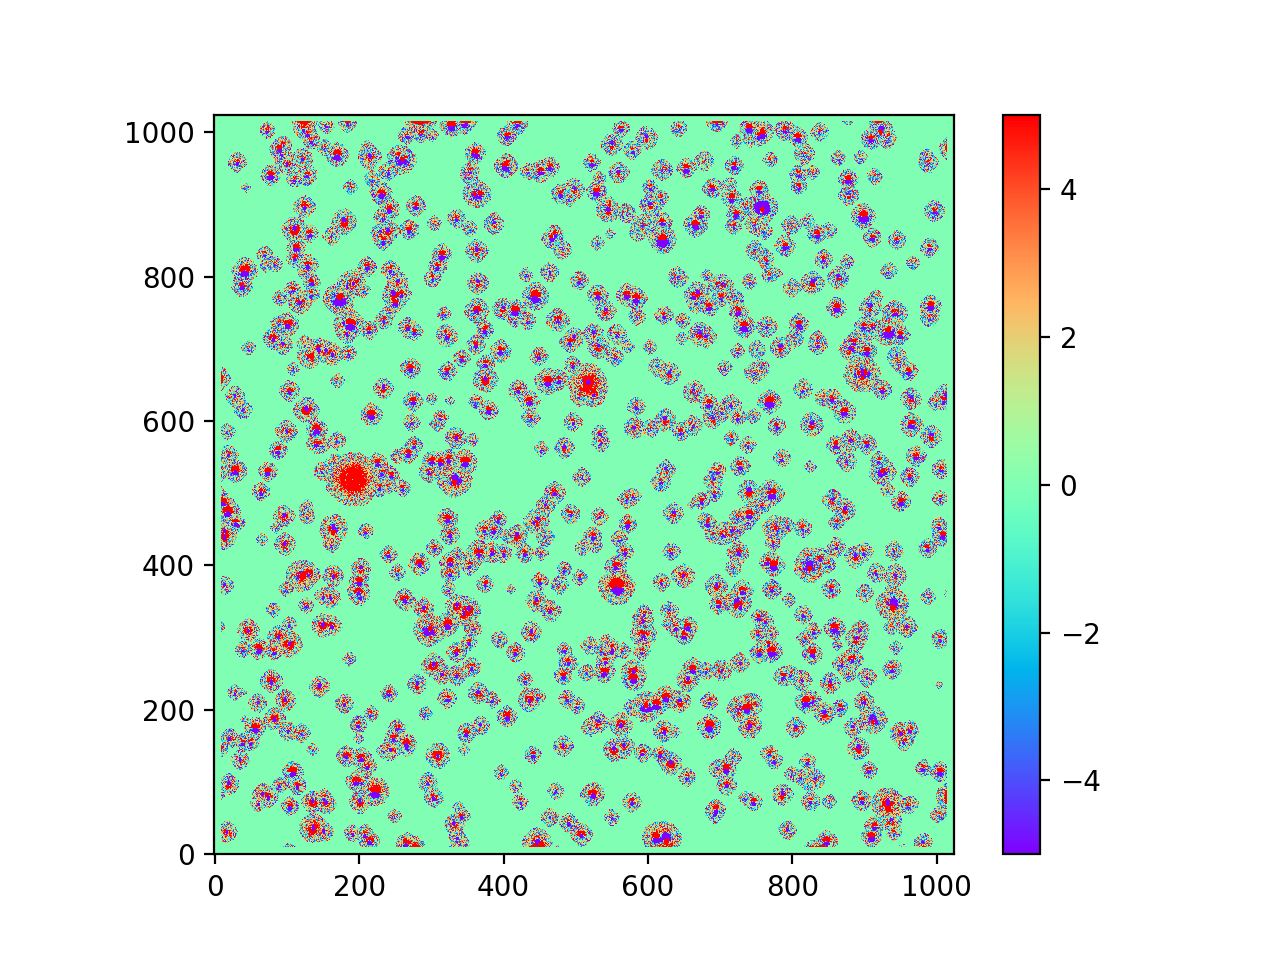

In [19]:
look(diffim_test, range=[-5,5])

In [20]:
np.mean(np.abs(diffim_dcr.image.array[np.isfinite(diffim_dcr.image.array)]))

3.9896755

In [21]:
butler0 = daf_persistence.Butler(base_dir + opsim_version + varPSF_run + deep_rerun_base + "1/")
ref_dataId = {'visit': visits_alerts[0][0] + 1, 'filter': 'g'}
significance_image = butler0.get("calexp", dataId=ref_dataId)
mask = significance_image.mask
significance_image = significance_image.image.array
significance_image[~np.isfinite(significance_image)] = 0.
significance_image = np.abs(significance_image)
significance_image[significance_image > 100] = 100.

In [22]:
template_deep = {}
alerts_deep = {}
for seeing_id in range(1, 9):
    seeing_name = "%i/" % seeing_id
    visits_template = [[1010000 + (seeing_id - 1)*100, 1010007 + (seeing_id - 1)*100]]
    template_deep0, alerts_deep0 = load_diffim(base_dir + opsim_version + varPSF_run,
                                               deep_rerun_base + seeing_name, dcr_rerun_base + seeing_name,
                                               visits_template, visits_alerts,
                                               filter_name='g', coaddName='deep',
                                               mask=mask, significance_image=significance_image)
    template_deep[seeing_id] = template_deep0
    alerts_deep[seeing_id] = alerts_deep0

Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.


In [23]:
template_dcr = {}
alerts_dcr = {}
for seeing_id in range(1, 9):
    seeing_name = "%i/" % seeing_id
    visits_template = [[1010000 + (seeing_id - 1)*100, 1010007 + (seeing_id - 1)*100]]
    template_dcr0, alerts_dcr0 = load_diffim(base_dir + opsim_version + varPSF_run,
                                             deep_rerun_base + seeing_name, dcr_rerun_base + seeing_name,
                                             visits_template, visits_alerts,
                                             filter_name='g', coaddName='dcr',
                                             mask=mask, significance_image=significance_image)
    template_dcr[seeing_id] = template_dcr0
    alerts_dcr[seeing_id] = alerts_dcr0

Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.
Skipping 2000021, no data.


In [24]:
alerts_dcr[8]

fieldId,year,visit,airmass,parAng,dcr [2],nDipole,nSrc,avgResidual,avgSrcResidual,psfSigma,nFalseNoise
str4,int64,int64,float64,float64,float64,int64,int64,float32,float32,float64,float64
0000,2,2000000,1.96842925691099,179.99999999999994,-2.154035021455455 .. 2.176960630762704e-15,23,47,28.735518,2.3902228,2.2854508767868427,0.04468941630783891
0000,2,2000001,1.14148927014087,0.0,0.6972581153245625 .. 0.0,1,1,12.267198,2.2405272,2.1146933143363444,0.0521979779913082
0000,2,2000002,1.02399901060398,0.0,0.27909283998020584 .. 0.0,1,2,10.34867,1.9658732,1.6884489688761983,0.08187901058193878
0000,2,2000003,1.1224052001487,179.99999999999994,-0.6456042715402546 .. 6.52475502114037e-16,4,7,12.124214,2.0079775,1.8420491454481709,0.06879328347783166
0000,2,2000004,1.04704096497713,0.0,0.3929814752808877 .. 0.0,0,1,11.552032,1.9774463,2.149955076244106,0.05049980414321539
0000,2,2000005,1.01787146166706,0.0,0.24047360729552558 .. 0.0,2,22,19.692883,2.3418813,1.4085839477261435,0.11764757906260923
0000,2,2000006,1.16676391805458,179.99999999999994,-0.7614823313213148 .. 7.695868636285238e-16,4,5,12.205566,1.9944949,2.038503945746593,0.05617270677974839
0000,2,2000007,1.03941757476497,0.0,0.35905484335173915 .. 0.0,0,1,9.935034,1.9576406,1.895619332372686,0.0649600283972974
0000,2,2000008,1.34813059735197,179.99999999999994,-1.145942355249229 .. 1.1581387338890345e-15,16,29,16.8852,2.0861032,1.900135682641376,0.0646515940253663


In [25]:
alerts_deep[8]

fieldId,year,visit,airmass,parAng,dcr [2],nDipole,nSrc,avgResidual,avgSrcResidual,psfSigma,nFalseNoise
str4,int64,int64,float64,float64,float64,int64,int64,float32,float32,float64,float64
0000,2,2000000,1.96842925691099,179.99999999999994,-2.154035021455455 .. 2.176960630762704e-15,67,109,23.060713,2.0294113,2.2854508767868427,0.04468941630783891
0000,2,2000001,1.14148927014087,0.0,0.6972581153245625 .. 0.0,6,27,16.677996,2.3377793,2.1146933143363444,0.0521979779913082
0000,2,2000002,1.02399901060398,0.0,0.27909283998020584 .. 0.0,9,117,18.32218,2.0434322,1.6884489688761983,0.08187901058193878
0000,2,2000003,1.1224052001487,179.99999999999994,-0.6456042715402546 .. 6.52475502114037e-16,35,111,18.51104,2.0168095,1.8420491454481709,0.06879328347783166
0000,2,2000004,1.04704096497713,0.0,0.3929814752808877 .. 0.0,5,24,16.17248,1.9835613,2.149955076244106,0.05049980414321539
0000,2,2000005,1.01787146166706,0.0,0.24047360729552558 .. 0.0,17,154,30.653467,2.4547806,1.4085839477261435,0.11764757906260923
0000,2,2000006,1.16676391805458,179.99999999999994,-0.7614823313213148 .. 7.695868636285238e-16,28,81,17.88153,2.006558,2.038503945746593,0.05617270677974839
0000,2,2000007,1.03941757476497,0.0,0.35905484335173915 .. 0.0,7,59,15.681264,1.9907527,1.895619332372686,0.0649600283972974
0000,2,2000008,1.34813059735197,179.99999999999994,-1.145942355249229 .. 1.1581387338890345e-15,48,136,20.888933,2.019956,1.900135682641376,0.0646515940253663


In [32]:
metrics = {}
for seeing_id in range(1, 9):
    metric = dcr_metric(template_dcr[seeing_id], '010%i' % (seeing_id - 1))
    metrics[seeing_id] = metric
print(metrics)

{1: 7.463093534506346, 2: 7.463093534506346, 3: 7.463093534506346, 4: 7.463093534506346, 5: 7.463093534506346, 6: 7.463093534506346, 7: 7.463093534506346, 8: 7.463093534506346}


Load the 2018 baseline survey

In [27]:
n_obs_list = [8, 8, 8]
repeat_obs = 3  # number of different fields with the given n_obs to generate simulations of
template_year = 1 
alert_year = 2
n_star = 10000
n_quasar = 1000

Connect to the database and set up for all of the simulations

Create a second set of simulations where the fields can be mosaiced together

In [28]:
airmass_threshold = 1.15  # Target fields must include at least one observation above this airmass to be included
opsim = OpSim_wrapper(year=template_year, filt='g', opsim_db='/Users/sullivan/LSST/OpSim/baseline2018a.db',
                      sim_directory="/Users/sullivan/LSST/simulations/OpSim/pontus_2568/",
                      conditions_db="/Users/sullivan/LSST/OpSim/pontus_2568.db",
                      airmass_threshold=airmass_threshold)

In [29]:
nx = repeat_obs
ny = len(n_obs_list)
n = nx if nx > ny else ny
simulation_size = n
dither_scale = 0.
dither_x = dither_scale*(np.arange(nx) - (nx - 1)/2)
dither_y = dither_scale*(np.arange(ny) - (ny - 1)/2)

In [30]:
initial_seeing_range = 1.
initial_var = True
seed = 42
randomize_conditions = True
randomize_template = True
n_alert = 24

Make a text file containing the visit list, and save the observing conditions

In [31]:
visits = None
mosaic = True
randomize_conditions = True
band_dict = {'u': 0, 'g': 1, 'r': 2, 'i': 3, 'z': 4, 'y': 5}
seeing_dict = {}
airmass_dict = {}
rng = np.random.RandomState(seed+3)
index = int(np.rint(rng.rand()*1000))
field_Id = 100
alert_field_Id = 0
seeing_range = initial_seeing_range
for d_y, n_obs in zip(dither_y, n_obs_list):
    for rpt in range(repeat_obs):
        d_x = dither_x[rpt]
        opsim.set_field(n_obs=4, index=index, year=template_year)
        field_Id0 = opsim.field_Id
        if randomize_template:
            opsim.update_year(template_year, randomize_conditions=randomize_conditions,
                              set_n_obs=n_obs, force_seeing_range=seeing_range)
        n_obs1 = len(opsim.airmass)
        for t_i in range(n_obs1):
            fieldId_i = 100*field_Id + 1000000*template_year + t_i
            seeing_dict[fieldId_i] = opsim.seeing[t_i]
            airmass_dict[fieldId_i] = opsim.airmass[t_i]
        
        opsim.field_Id = field_Id
        if mosaic:
            visit_name1 = "%i" % (100*opsim.field_Id + 1000000*template_year)
            visit_name1b = "%i" % (100*opsim.field_Id + 1000000*template_year + n_obs1 - 1)
        else:
            visit_name1 = "%i" % (100*band_dict[opsim.filter] + 1000*template_year)
            visit_name1b = "%i" % (100*band_dict[opsim.filter] + 1000*template_year + n_obs1 - 1)
        if visits is None:
            visits = visit_name1
        else:
            visits += "^" + visit_name1
        visits += "..%s" % visit_name1b
        field_Id += 1
        seeing_range *= 1.1

d_x = 0
d_y = 0
opsim.set_field(n_obs=4, index=index, year=alert_year)
if randomize_template:
    opsim.update_year(alert_year, randomize_conditions=randomize_conditions,
                      set_n_obs=n_alert)
n_obs1 = len(opsim.airmass)
for t_i in range(n_obs1):
    fieldId_i = 100*alert_field_Id + 1000000*alert_year + t_i
    seeing_dict[fieldId_i] = opsim.seeing[t_i]
    airmass_dict[fieldId_i] = opsim.airmass[t_i]
opsim.field_Id = alert_field_Id
if mosaic:
    visit_name2 = "%i" % (100*opsim.field_Id + 1000000*alert_year)
    visit_name2b = "%i" % (100*opsim.field_Id + 1000000*alert_year + n_obs1 - 1)
else:
    visit_name2 = "%i" % (100*band_dict[opsim.filter] + 1000*alert_year)
    visit_name2b = "%i" % (100*band_dict[opsim.filter] + 1000*alert_year + n_obs1 - 1)
visits += "^" + visit_name2
visits += "..%s" % visit_name2b

Selecting 13 obs from field 2575, with seeing range 0.622 to 0.999 and airmass range 1.123 to 1.190
Selecting 8 randomized obs from field 2575, with seeing range 0.524 to 0.524 and airmass range 1.012 to 1.484
Selecting 13 obs from field 2575, with seeing range 0.622 to 0.999 and airmass range 1.123 to 1.190
Selecting 8 randomized obs from field 2575, with seeing range 0.524 to 0.577 and airmass range 1.012 to 1.484
Selecting 13 obs from field 2575, with seeing range 0.622 to 0.999 and airmass range 1.123 to 1.190
Selecting 8 randomized obs from field 2575, with seeing range 0.524 to 0.635 and airmass range 1.012 to 1.484
Selecting 13 obs from field 2575, with seeing range 0.622 to 0.999 and airmass range 1.123 to 1.190
Selecting 8 randomized obs from field 2575, with seeing range 0.524 to 0.698 and airmass range 1.012 to 1.484
Selecting 13 obs from field 2575, with seeing range 0.622 to 0.999 and airmass range 1.123 to 1.190
Selecting 8 randomized obs from field 2575, with seeing rang

In [33]:
seeing_dict

{1010000: 0.5244374092174477,
 1010001: 0.5244374092174477,
 1010002: 0.5244374092174477,
 1010003: 0.5244374092174477,
 1010004: 0.5244374092174477,
 1010005: 0.5244374092174477,
 1010006: 0.5244374092174477,
 1010007: 0.5244374092174477,
 1010100: 0.5768811501391926,
 1010101: 0.5372874608334048,
 1010102: 0.5583353681225943,
 1010103: 0.5431252897328596,
 1010104: 0.5350322774828323,
 1010105: 0.566082489925671,
 1010106: 0.5244374092174477,
 1010107: 0.5577056444149199,
 1010200: 0.6345692651531118,
 1010201: 0.5514225176109577,
 1010202: 0.5956231229182556,
 1010203: 0.5636819582998125,
 1010204: 0.5466866325747554,
 1010205: 0.6118920787047166,
 1010206: 0.5244374092174477,
 1010207: 0.5943007031321392,
 1010300: 0.6980261916684232,
 1010301: 0.5669710800662658,
 1010302: 0.636639653193483,
 1010303: 0.5862942937234608,
 1010304: 0.5595064231758706,
 1010305: 0.6622826263616668,
 1010306: 0.5244374092174477,
 1010307: 0.6345552677210806,
 1010400: 0.7678288108352656,
 1010401: 0.

Plot the results

In [34]:
seeing_range = {}
seeing = 1.0
for seeing_id in range(1,9):
    seeing_range[seeing_id] = (seeing - 1)*100
    seeing *= 1.1

In [35]:
np.mean(alerts_deep[1]["nDipole"])

16.956521739130434

In [36]:
print("Seeing range \t deep \t dcr")
for seeing_id in range(1, 9):
    print("\t%2.0f%%: \t%3.0f\t%3.0f" % (seeing_range[seeing_id],
                                         np.median(alerts_deep[seeing_id]["nDipole"]),
                                         np.median(alerts_dcr[seeing_id]["nDipole"])))

Seeing range 	 deep 	 dcr
	 0%: 	  9	  1
	10%: 	 11	  1
	21%: 	 10	  2
	33%: 	 15	  2
	46%: 	 13	  2
	61%: 	 13	  3
	77%: 	 13	  3
	95%: 	 17	  3


In [37]:
print("Seeing range \t deep \t dcr")
for seeing_id in range(1, 9):
    print("\t%2.0f%%: \t%3.0f\t%3.0f" % (seeing_range[seeing_id],
                                         np.median(alerts_deep[seeing_id]["nSrc"]),
                                         np.median(alerts_dcr[seeing_id]["nSrc"])))

Seeing range 	 deep 	 dcr
	 0%: 	 27	  2
	10%: 	 31	  2
	21%: 	 29	  3
	33%: 	 27	  4
	46%: 	 26	  4
	61%: 	 50	  5
	77%: 	 65	  5
	95%: 	109	  5


In [38]:
print("Seeing range \t deep \t dcr")
for seeing_id in range(1, 9):
    print("\t%2.0f%%: \t%4.2f\t%4.2f" % (seeing_range[seeing_id],
                                       np.median(alerts_deep[seeing_id]["avgResidual"]),
                                       np.median(alerts_dcr[seeing_id]["avgResidual"])))

Seeing range 	 deep 	 dcr
	 0%: 	16.78	14.73
	10%: 	16.81	14.83
	21%: 	17.12	15.10
	33%: 	17.21	15.56
	46%: 	15.39	13.88
	61%: 	17.67	14.06
	77%: 	16.09	11.18
	95%: 	18.71	12.27


In [39]:
print("Seeing range \t deep \t dcr")
for seeing_id in range(1, 9):
    print("\t%2.0f%%: \t%4.2f\t%4.2f" % (seeing_range[seeing_id],
                                       np.median(alerts_deep[seeing_id]["avgSrcResidual"]),
                                       np.median(alerts_dcr[seeing_id]["avgSrcResidual"])))

Seeing range 	 deep 	 dcr
	 0%: 	2.09	2.03
	10%: 	2.08	2.04
	21%: 	2.07	2.04
	33%: 	2.04	2.03
	46%: 	2.02	2.02
	61%: 	2.06	2.04
	77%: 	2.04	2.02
	95%: 	2.04	2.02


In [100]:
seeing_range[3]

21.000000000000018

In [128]:
def plot_diffim_combined(deep_tables, dcr_tables, seeing_range,
                         quantity="nDipole", window=1, seeing_list=None,
                         **kwargs):
    afwDisplay.Display(window)
    plt.figure(window)
    colors = 'bgrcmyk'
    names = []
    if seeing_list is None:
        seeing_list = [seeing_id for seeing_id in seeing_range.keys()]
    for ind, seeing_id in enumerate(seeing_list):
        names.append("%2.0f%%" % seeing_range[seeing_id])
        deep_table = deep_tables[seeing_id]
        dcr_table = dcr_tables[seeing_id]

        q1 = deep_table[quantity].quantity
        q2 = dcr_table[quantity].quantity
        airmass = deep_table["airmass"].quantity
        x = airmass
        y = (q1 - q2)/q1
        plt.plot(x, y, colors[ind] + '+')
        plt.grid(True)
    plt.ylabel('Fractional reduction in false detections')
    plt.xlabel('Airmass')
    plt.legend(names)

<IPython.core.display.Javascript object>


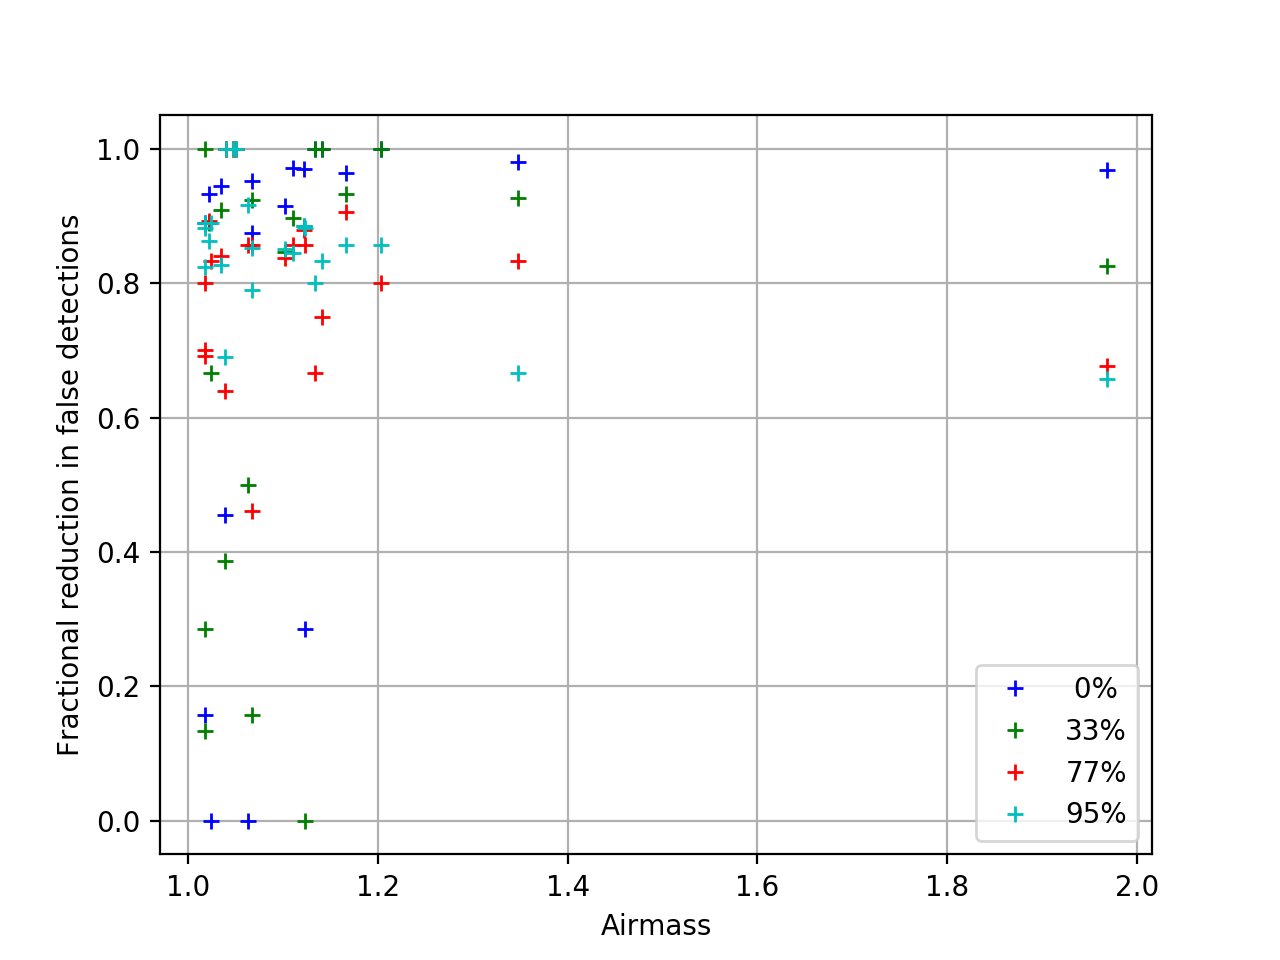

In [135]:
plot_diffim_combined(alerts_deep, alerts_dcr, seeing_range, window=31, seeing_list=[1,4,7,8], quantity='nDipole')

<IPython.core.display.Javascript object>


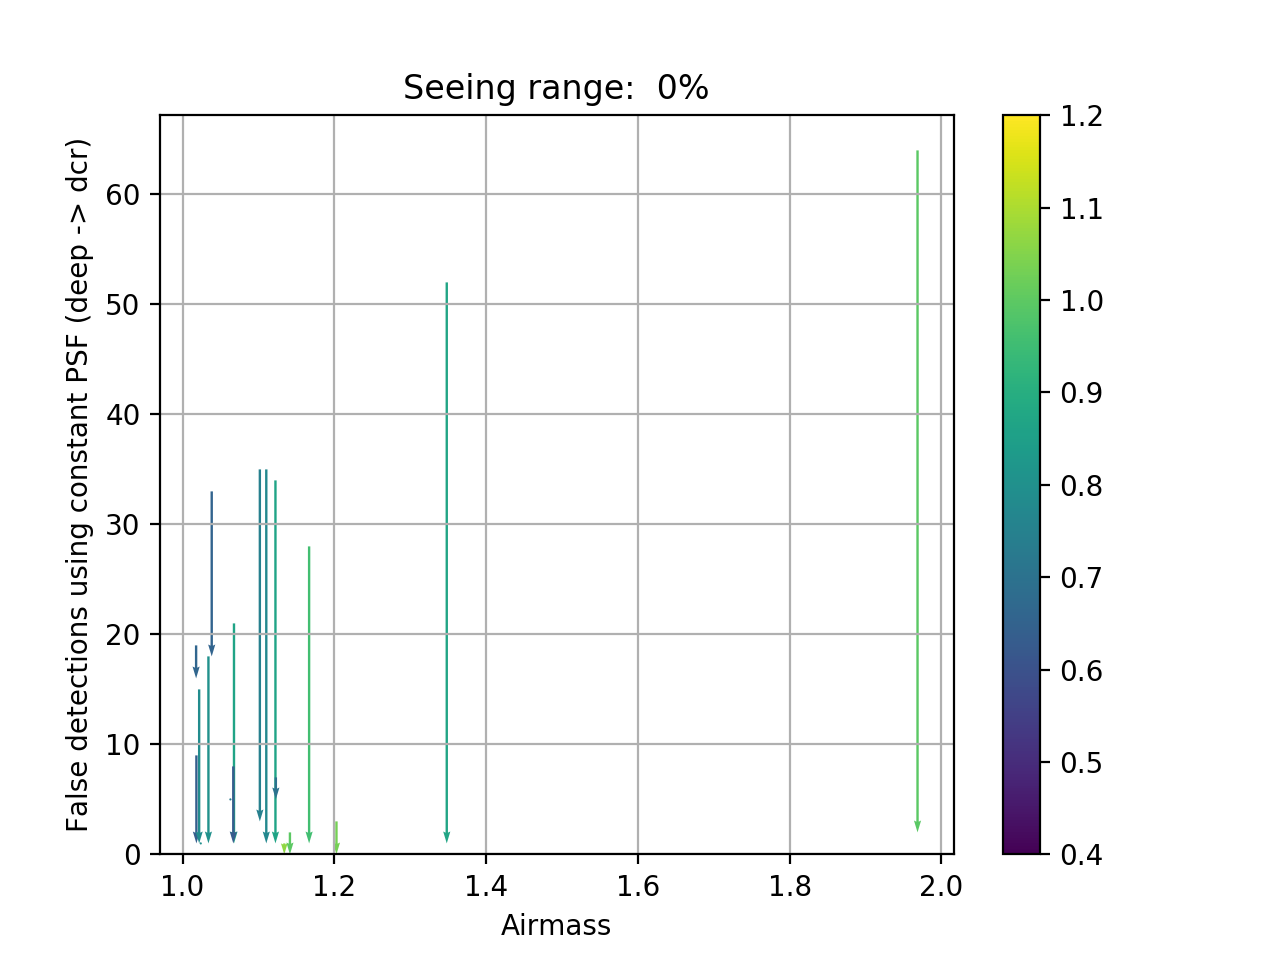

Text(0.5, 1.0, 'Seeing range:  0%')

In [40]:
seeing_id = 1
plot_diffim_quiver(alerts_deep[seeing_id], alerts_dcr[seeing_id],
                   psf_name='constant', window=seeing_id+2, width=3e-3, seeing_dict=seeing_dict)
plt.title("Seeing range: %2.0f%%" % seeing_range[seeing_id])

<IPython.core.display.Javascript object>


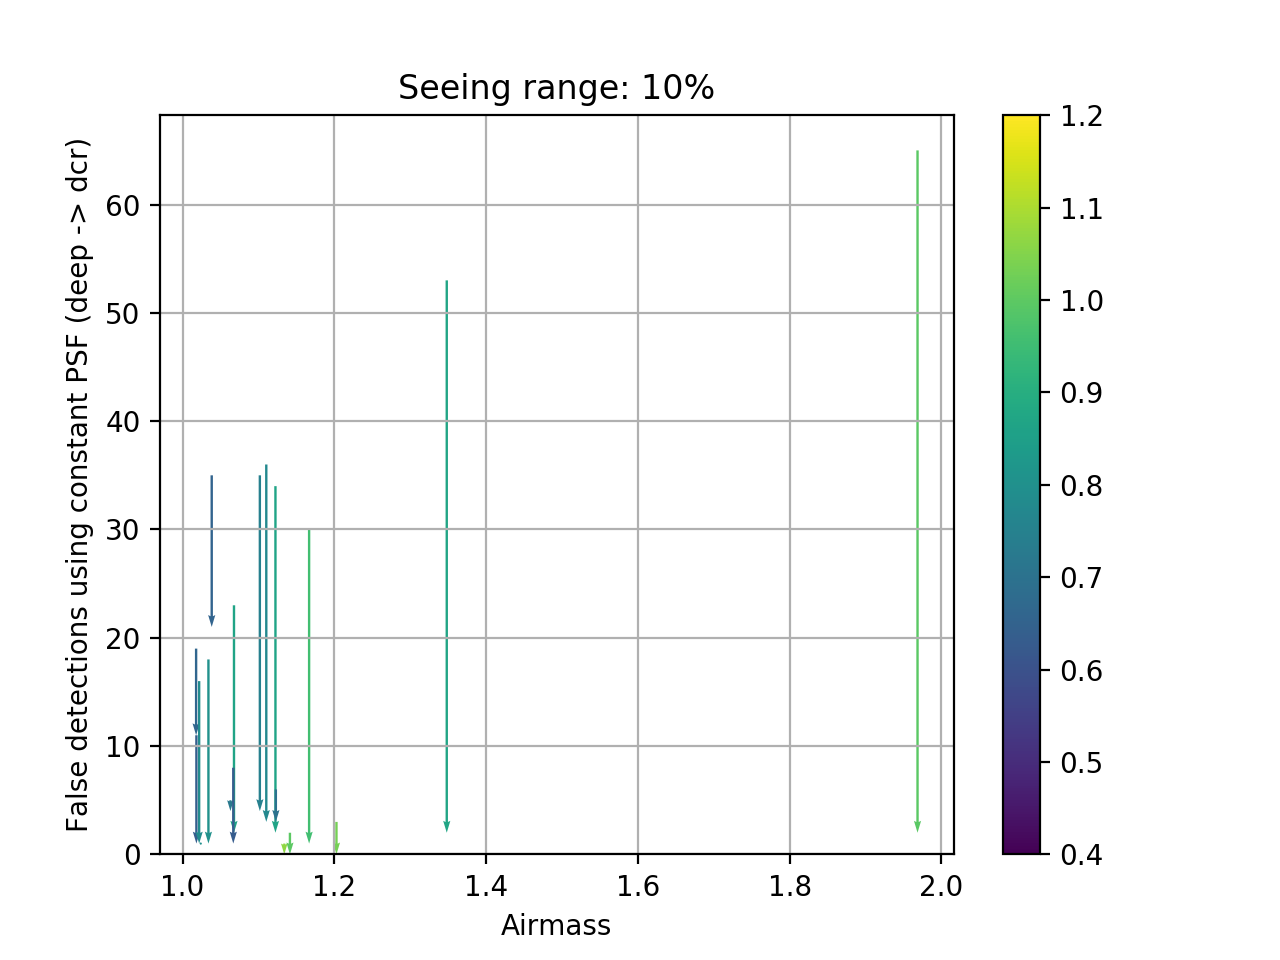

Text(0.5, 1.0, 'Seeing range: 10%')

In [41]:
seeing_id = 2
plot_diffim_quiver(alerts_deep[seeing_id], alerts_dcr[seeing_id],
                   psf_name='constant', window=seeing_id+2, width=3e-3, seeing_dict=seeing_dict)
plt.title("Seeing range: %2.0f%%" % seeing_range[seeing_id])

<IPython.core.display.Javascript object>


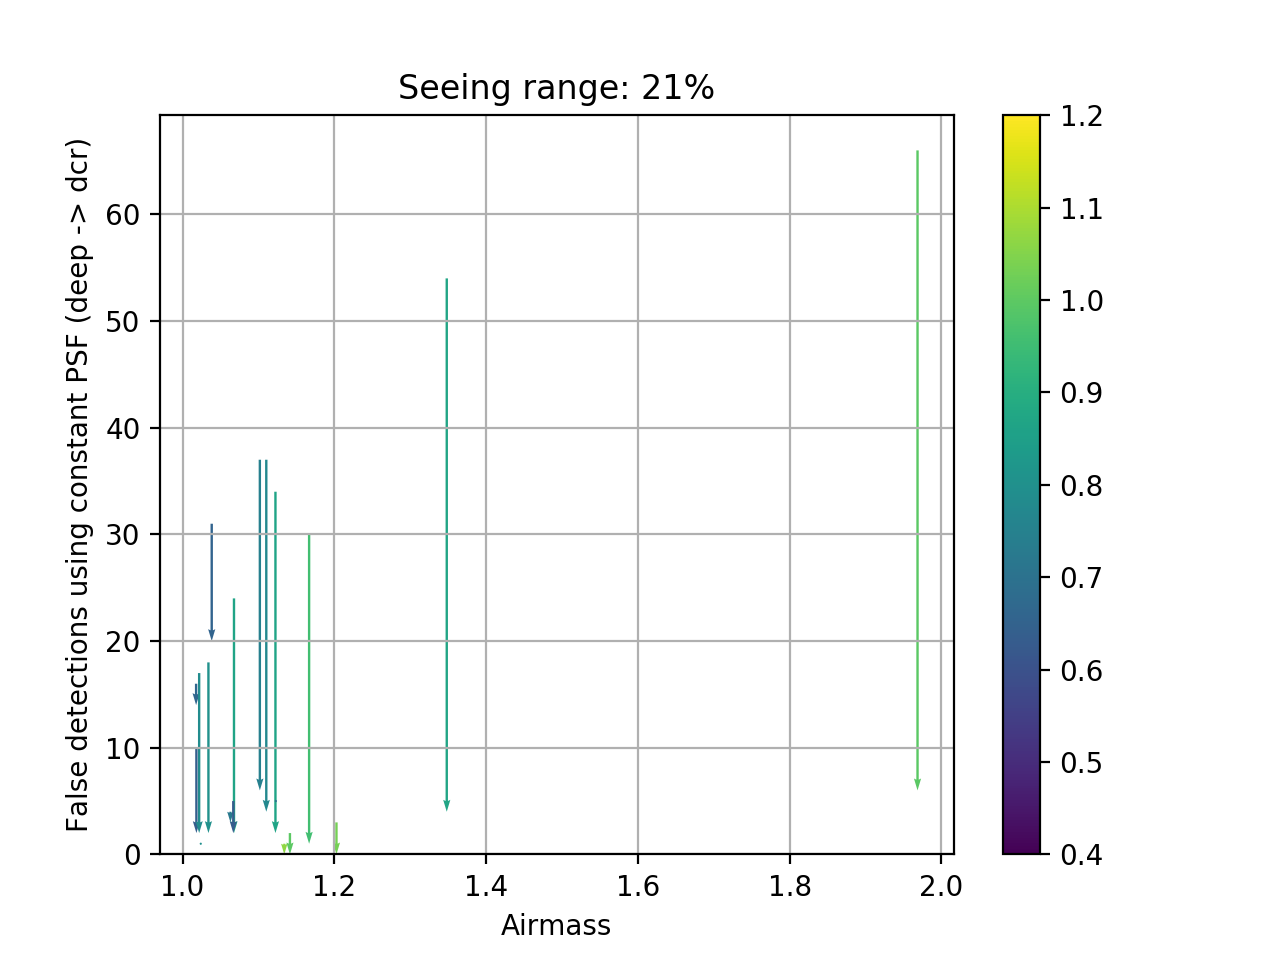

Text(0.5, 1.0, 'Seeing range: 21%')

In [42]:
seeing_id = 3
plot_diffim_quiver(alerts_deep[seeing_id], alerts_dcr[seeing_id],
                   psf_name='constant', window=seeing_id+2, width=3e-3, seeing_dict=seeing_dict)
plt.title("Seeing range: %2.0f%%" % seeing_range[seeing_id])

<IPython.core.display.Javascript object>


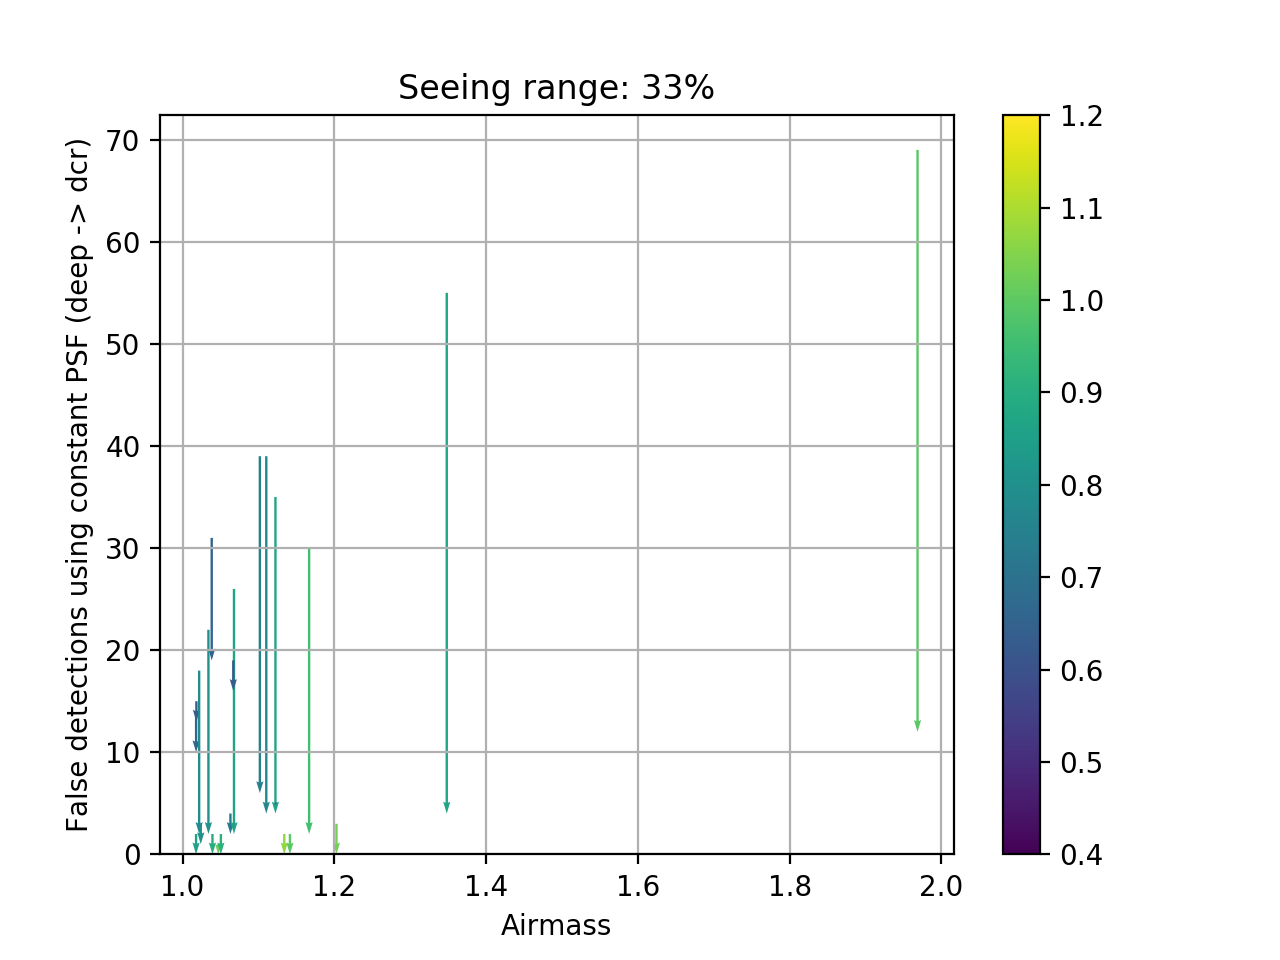

Text(0.5, 1.0, 'Seeing range: 33%')

In [43]:
seeing_id = 4
plot_diffim_quiver(alerts_deep[seeing_id], alerts_dcr[seeing_id],
                   psf_name='constant', window=seeing_id+2, width=3e-3, seeing_dict=seeing_dict)
plt.title("Seeing range: %2.0f%%" % seeing_range[seeing_id])

<IPython.core.display.Javascript object>


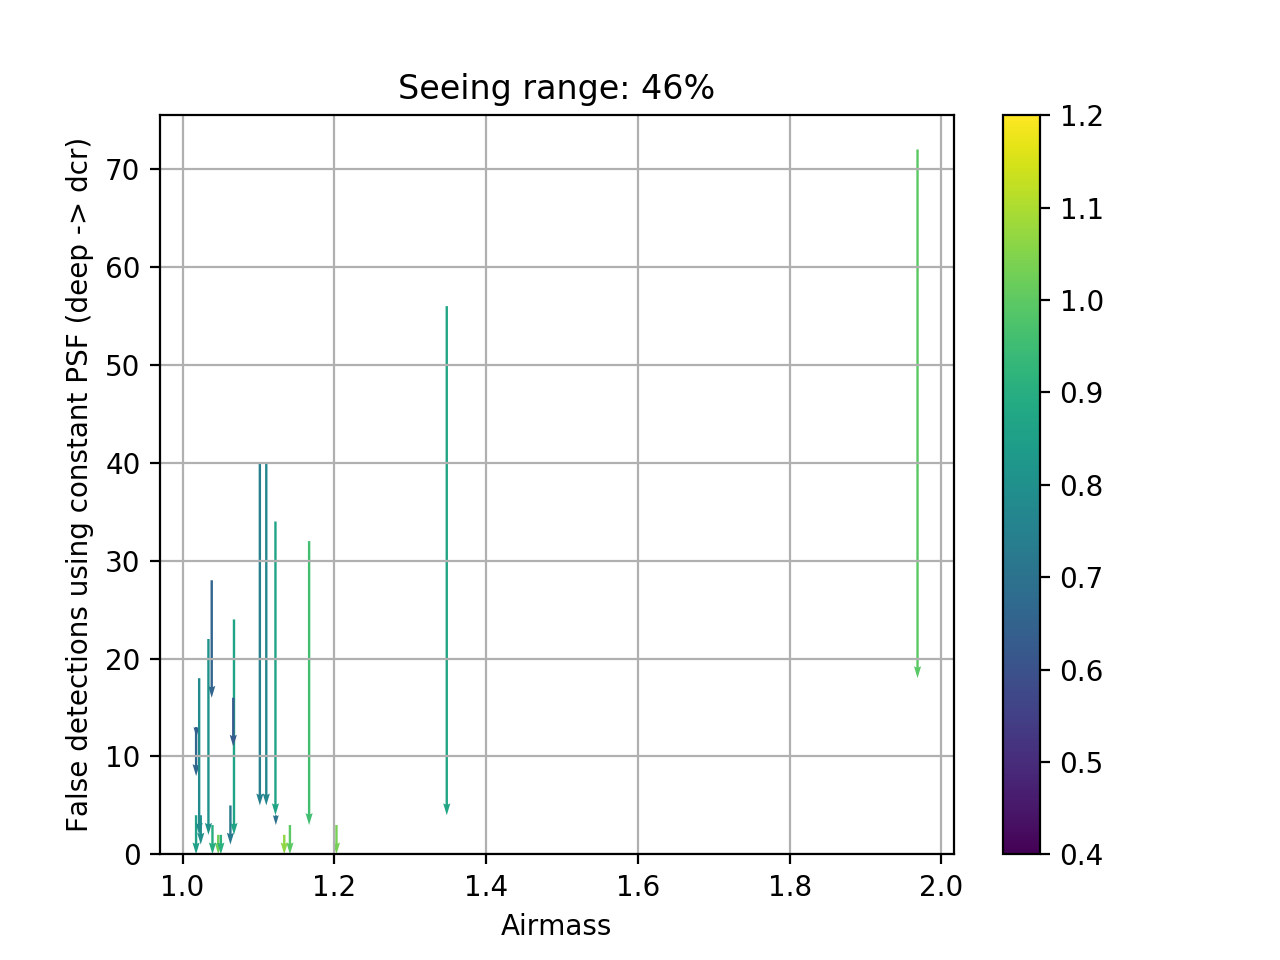

Text(0.5, 1.0, 'Seeing range: 46%')

In [44]:
seeing_id = 5
plot_diffim_quiver(alerts_deep[seeing_id], alerts_dcr[seeing_id],
                   psf_name='constant', window=seeing_id+2, width=3e-3, seeing_dict=seeing_dict)
plt.title("Seeing range: %2.0f%%" % seeing_range[seeing_id])

<IPython.core.display.Javascript object>


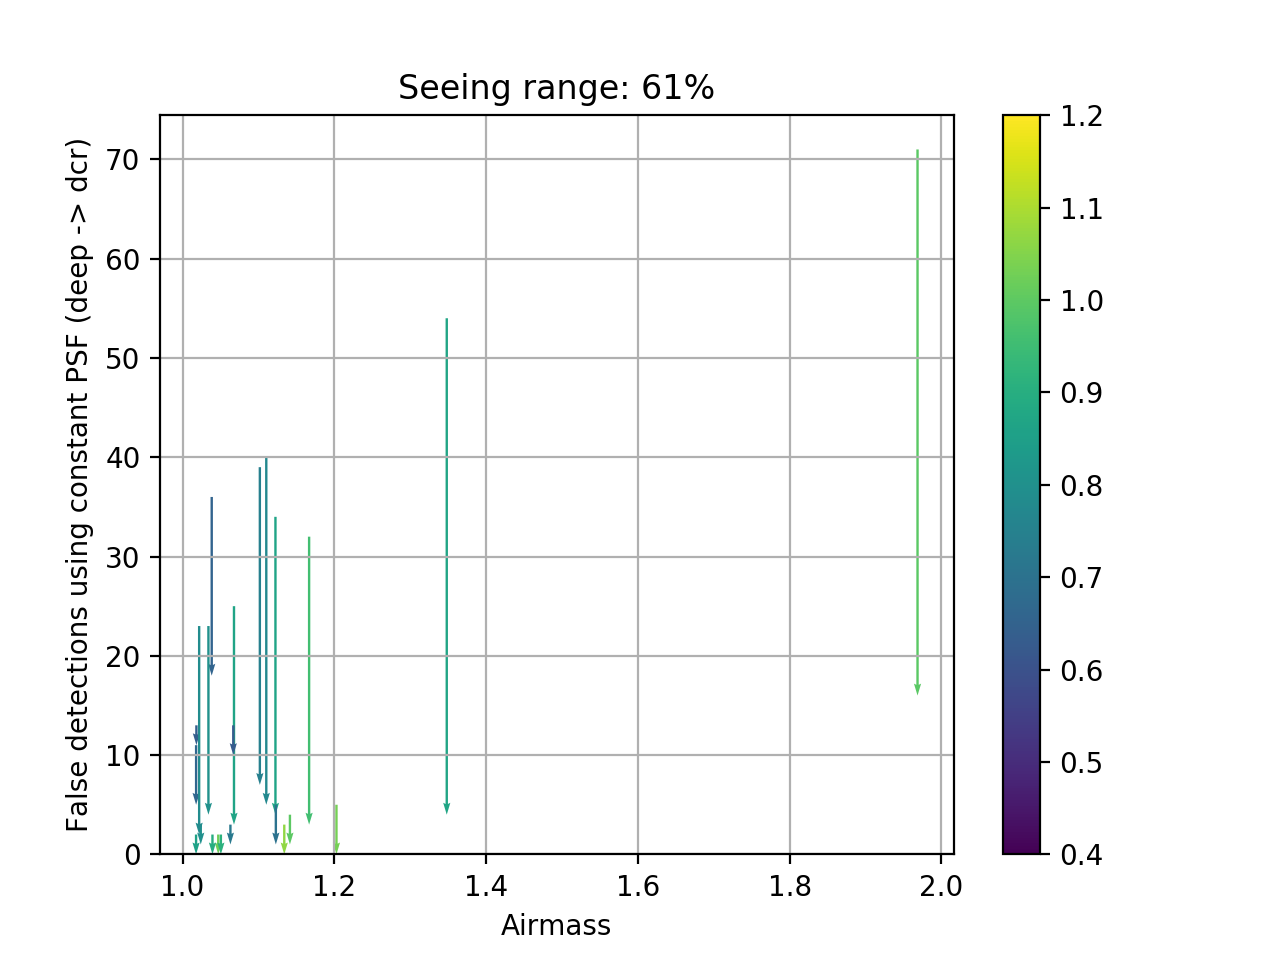

Text(0.5, 1.0, 'Seeing range: 61%')

In [45]:
seeing_id = 6
plot_diffim_quiver(alerts_deep[seeing_id], alerts_dcr[seeing_id],
                   psf_name='constant', window=seeing_id+2, width=3e-3, seeing_dict=seeing_dict)
plt.title("Seeing range: %2.0f%%" % seeing_range[seeing_id])

<IPython.core.display.Javascript object>


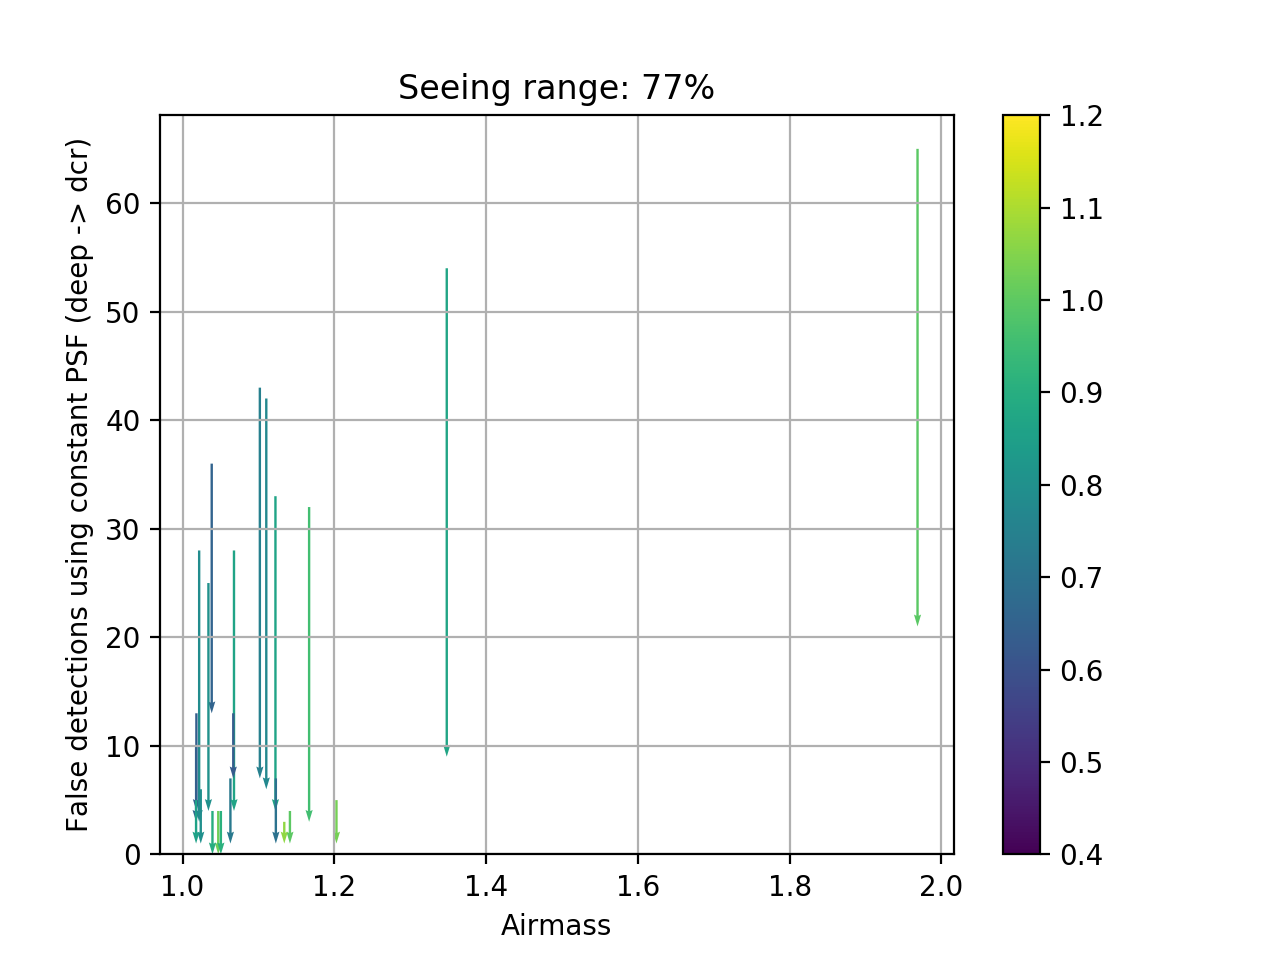

Text(0.5, 1.0, 'Seeing range: 77%')

In [46]:
seeing_id = 7
plot_diffim_quiver(alerts_deep[seeing_id], alerts_dcr[seeing_id],
                   psf_name='constant', window=seeing_id+2, width=3e-3, seeing_dict=seeing_dict)
plt.title("Seeing range: %2.0f%%" % seeing_range[seeing_id])

<IPython.core.display.Javascript object>


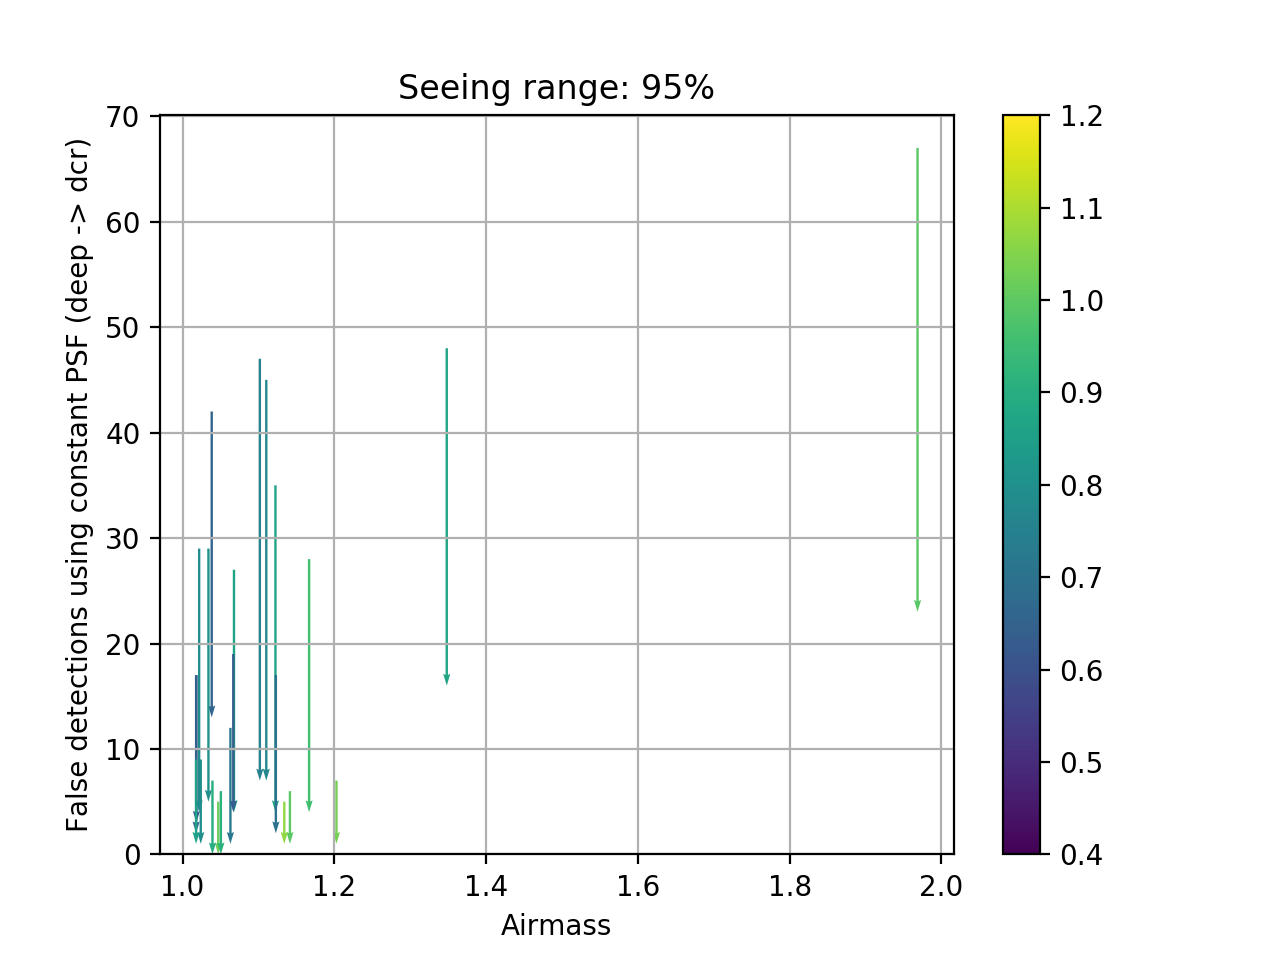

Text(0.5, 1.0, 'Seeing range: 95%')

In [47]:
seeing_id = 8
plot_diffim_quiver(alerts_deep[seeing_id], alerts_dcr[seeing_id],
                   psf_name='constant', window=seeing_id+2, width=3e-3, seeing_dict=seeing_dict)
plt.title("Seeing range: %2.0f%%" % seeing_range[seeing_id])